In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

# Change this depending on your data.
taxonomic_rank = 'Genus'
base_path = "pipelines/bmock12/wgsa2/"
rel_abund_file = "cleaned_pct.csv"
program_name = "WGSA"

In [47]:
# Generate the expected result from the tsv file. Returns a dataframe.
def generate_expected(input_path: str, plot: bool = False) -> pd.DataFrame:
    expected = pd.read_csv(input_path, sep='\t', index_col=0, names=['Organism', 'Counts'], header=0)
    expected = expected[['Counts']].astype(int)

    # Calculate expected relative abundance.
    expected['RA'] = expected['Counts'] / expected['Counts'].sum()

    # Let's split the organism index into two columns to find the genera.
    orgs = expected.index.to_list()
    genus = [org.strip().split(' ')[0] for org in orgs]
    genus = [x.replace('M.', 'Micromonospora') for x in genus]

    # Apparently, propionibacterium have been renamed to cutibacterium.
    genus = [x.replace('Propionibact.', 'Cutibacterium') for x in genus]

    # Add the columns to the dataframe.
    expected['Genus'] = genus
    display(expected.head(12))

    # Group by genus and sum the counts for overlapping genera.
    exp_genus = expected.groupby('Genus').sum()
    exp_genus.sort_values('RA', ascending=False, inplace=True)

    if plot:
        exp_genus.plot.bar(y='RA', figsize=(8, 5), legend=False, title='Expected Relative Abundance')
    
    return exp_genus

exp_genus = generate_expected('expected.tsv')

,Counts,RA,Genus
Organism,,,
Muricauda sp.,74263482,0.180311,Muricauda
Psychrobacter sp.,45769662,0.111128,Psychrobacter
Marinobacter sp. 8,64862842,0.157486,Marinobacter
Marinobacter sp. 1,20090318,0.048779,Marinobacter
Cohaesibacter sp.,29119402,0.070702,Cohaesibacter
Halomonas sp. HL-4,71778728,0.174278,Halomonas
Halomonas sp. HL-93,80284678,0.194930,Halomonas
Thioclava sp.,12987850,0.031534,Thioclava
Propionibact. b.,4794346,0.011641,Cutibacterium


In [51]:
def generate_experimental_df(input_path: str, index_name: str) -> pd.DataFrame:
    # Now, load in the experimental values.
    r_genus = pd.read_csv(input_path, index_col=0, names=[index_name, "RA"], header=0)
    # display(r_genus.head(12))
    r_genus = r_genus[['RA']].astype(float)

    return r_genus

# Instead, let's concat the two dataframes into long format and add a column from where it originated.
def long_format(df1, df2):
    merged = pd.concat([df1, df2], axis=0)

    # !!! This is slick
    merged['Source'] = ['Expected'] * len(df1) + ['Observed'] * len(df2)

    return merged

result_genus = generate_experimental_df(os.path.join(base_path, rel_abund_file), taxonomic_rank)
merged = long_format(exp_genus, result_genus)

,Counts,RA,Source
Genus,,,
Halomonas,152063406.0,3.692082e-01,Expected
Marinobacter,84953160.0,2.062653e-01,Expected
Muricauda,74263482.0,1.803109e-01,Expected
Psychrobacter,45769662.0,1.111282e-01,Expected
Cohaesibacter,29119402.0,7.070158e-02,Expected
...,...,...,...
Zunongwangia,NaN,1.158329e-04,Observed
Zygotorulaspora,NaN,1.784515e-08,Observed
Zymobacter,NaN,4.425597e-06,Observed


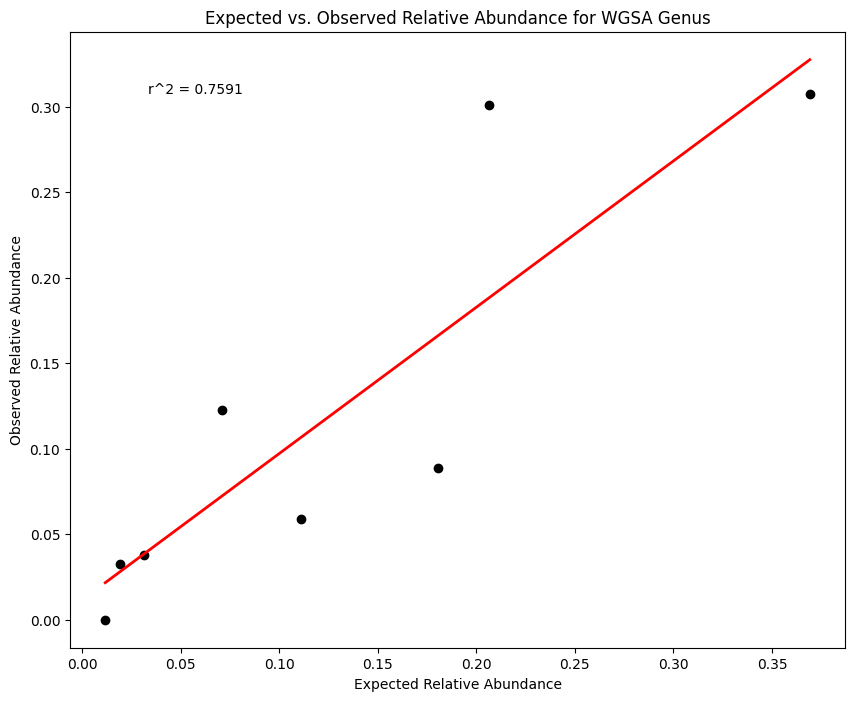

,Counts,RA_x,RA_y
Genus,,,
Halomonas,152063406,0.369208,0.307344
Marinobacter,84953160,0.206265,0.301148
Muricauda,74263482,0.180311,0.088886
Psychrobacter,45769662,0.111128,0.058854
Cohaesibacter,29119402,0.070702,0.122395
Thioclava,12987850,0.031534,0.037652
Micromonospora,7912204,0.019211,0.032834
Cutibacterium,4794346,0.011641,0.000042


In [49]:
def linear_regression(df: pd.DataFrame, plot: bool = False, save_path: str = None) -> pd.DataFrame:
    # Merge on the genus key for easy plotting. The expected results are on the left, the observed on the right.
    # linear_df = exp_genus.merge(df, left_index=True, right_index=True)

    # try join because the left merge will drop the genera that are not in the observerd results, but we want to show that the experimental missed it.
    linear_df = exp_genus.join(df, how='left', lsuffix='_x', rsuffix='_y')
    linear_df.fillna(0, inplace=True)

    # Linear regression with scikit.
    X = linear_df['RA_x'].values.reshape(-1, 1)
    Y = linear_df['RA_y'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    # Scatter plot of RA_x vs. RA_y.
    if plot:
        fig = plt.figure(figsize=(10, 8))
        plt.scatter(linear_df['RA_x'], linear_df['RA_y'], color='black')

        # Regression line.
        plt.plot(X, y_pred, color='red', linewidth=2)
        # Labels.
        plt.xlabel('Expected Relative Abundance')
        plt.ylabel('Observed Relative Abundance')
        plt.title(f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}')
        # Add r^2 value.
        plt.text(0.1, 0.9, f'r^2 = {reg.score(X,Y):.4f}', transform=plt.gca().transAxes)

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()
    
    return linear_df
    
linear_regression(result_genus, plot=True, save_path=os.path.join(base_path, f"bivariate_{taxonomic_rank}.png"))

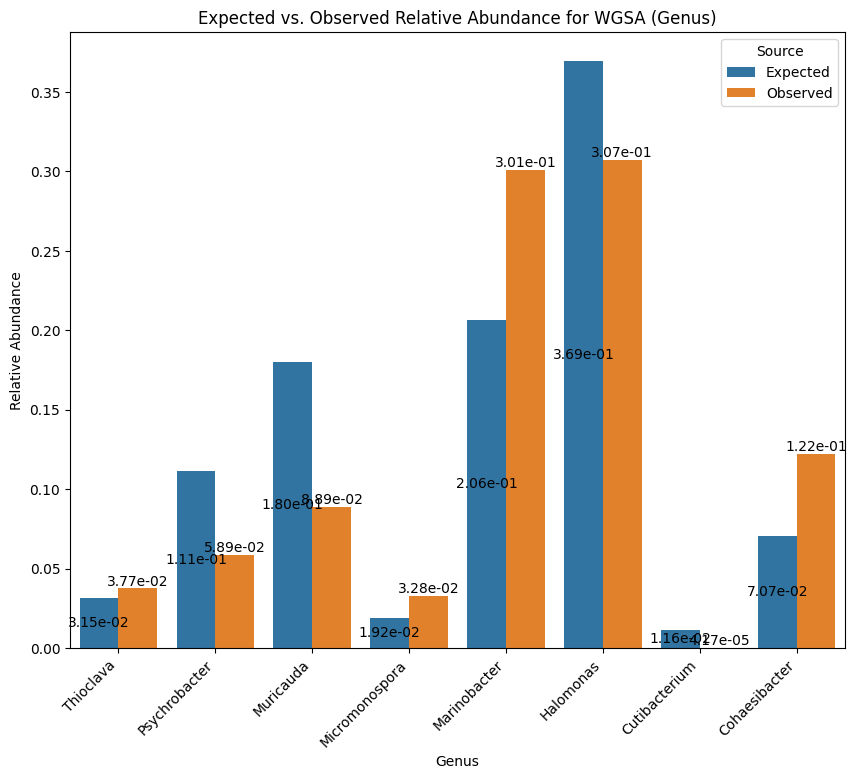

In [50]:
# Bar plot of RA_x vs. RA_y side by side.
# sns.set_style("whitegrid")
def bar_plot(df: pd.DataFrame, plot: bool = False, save_path: str = None):
    subset = pd.DataFrame()

    for x, y in df.groupby(taxonomic_rank):
        if y["Source"].values[0] == "Expected":
            subset = pd.concat([y, subset], axis=0)

    if plot:
        # Plot a category bar chart with the colors besed on the source.
        fig = plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=subset.index, y='RA', hue='Source', data=subset, palette=['#1f77b4', '#ff7f0e'])
        ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
        ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_title(f'Expected vs. Observed Relative Abundance for {program_name} ({taxonomic_rank})')
        ax.set_xlabel('Genus')
        ax.set_ylabel('Relative Abundance')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

bar_plot(merged, plot=True, save_path=os.path.join(base_path, f"bars_{taxonomic_rank}.png"))